In [19]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('lib')
from lib.read_data import *
import os

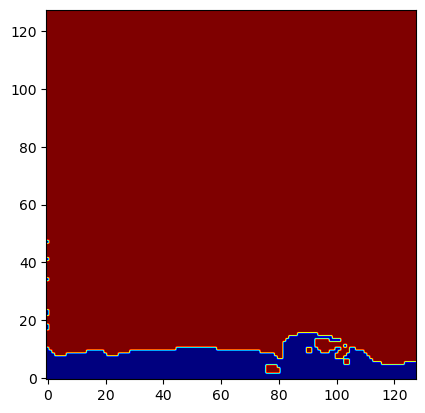

In [39]:
N = 128
frame = 25
dir = f"{DATA_PATH}/dambreak_N{N}_200"
flags = read_flags(f"{dir}/flags_{frame}.bin")
plt.imshow(flags.reshape(N, N).T, origin='lower', cmap='jet')
plt.show()

In [40]:
from scipy.ndimage import label
structure = np.ones((3, 3))
labeled, ncomponents = label((flags == 2).reshape(N, N), structure)

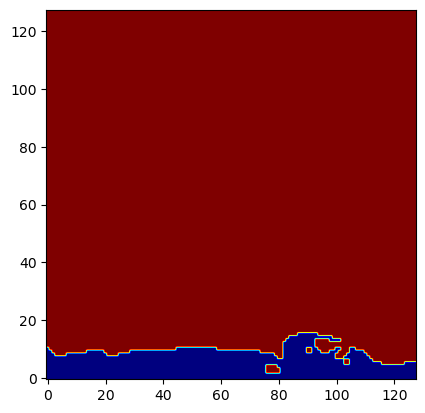

In [41]:
window_size = 50
for i in range(1, ncomponents+1):
    label1 = np.where(labeled == i)
    if len(label1[0]) < window_size:
        labeled[label1] = 0
flags_denoised = np.where(labeled == 0, 3, 2)
np.save(f"{dir}/flags_{frame}_denoised.npy", flags_denoised)
plt.imshow(flags_denoised.reshape(N, N).T, origin='lower', cmap='jet')
plt.show()

In [42]:
from lib.create_dataset import *

flags_denoised = flags_denoised.ravel()

rhs = load_vector(f"{dir}/div_v_star_{frame}.bin", dtype='d')
sol = load_vector(f"{dir}/pressure_{frame}.bin", dtype='d')

A = readA_sparse(f"{dir}/A_{frame}.bin", dtype='d')

In [43]:
num_ritz_vectors = 200
A_denoised = compressedMat(A, flags_denoised)
rhs_denoised = compressedVec(rhs, flags_denoised)
ritz_vals, ritz_vec = createRitzVec(A_denoised, rhs_denoised, num_ritz_vectors)

Lanczos Iteration is running...
[3.29741564 3.77981234 3.82594148 3.86564837 4.15595177 3.95012942
 3.8526255  4.00666511 3.95542227 3.95977541 4.134832   3.9360372
 3.90406414 3.91720116 4.07505071 4.08587746 3.94530087 3.84293527
 4.02961505 4.0695864  3.90737508 3.80591893 3.91677458 4.05224981
 3.97512662 3.89490693 4.08027389 3.94468435 4.03898506 3.95502172
 4.01766634 3.93761233 3.93001694 3.93448308 4.01182577 4.19536281
 3.91009996 3.84841995 3.92908774 3.92882758 4.00183237 3.86840532
 3.99448834 4.07339697 3.95093906 3.92012248 3.83256664 3.93397514
 3.94577672 3.99528734 4.14076072 3.98001809 3.81184886 4.06198566
 4.00478946 3.88010146 4.00197746 3.89153343 3.94066673 3.77423628
 4.06466028 4.02297406 4.0136857  3.87376521 3.98540648 4.00652761
 3.81107817 3.97832327 3.93543981 3.89081573 3.92783712 4.09323061
 4.10233077 3.8864313  4.1663128  3.99887556 3.89215481 3.93905623
 4.02549843 3.72096239 4.07920075 3.91893822 3.90222137 4.09173477
 4.00259558 3.97630731 3.979865

In [44]:
out = f"{dir}/preprocessed/{frame}"
os.makedirs(out, exist_ok=True)
fp = np.memmap(f"{out}/ritz_{num_ritz_vectors}_denoised.dat", dtype=np.float32, mode='w+', shape=ritz_vec.shape)
fp[:] = ritz_vec
fp.flush()

In [45]:
import torch

torch.save(torch.tensor(flags_denoised, dtype=torch.float32), os.path.join(out, "flags_denoised.pt"))

In [38]:
sample_size = 200
theta = 200 # j < m/2 + theta low frequency spectrum

fluid_cells = np.where(flags_denoised == 2)[0]
b_rhs_temp = np.zeros([sample_size, len(fluid_cells)])
cut_idx = int(num_ritz_vectors/2) + theta
sample_size = sample_size
coef_matrix = np.zeros([len(ritz_vec), sample_size])
coef_matrix[:] = np.random.normal(0, 1, [len(ritz_vec), sample_size])
coef_matrix[0:cut_idx] *= 9
b_rhs_temp[:] = coef_matrix.T @ ritz_vec
for i in range(sample_size):
    b_rhs_temp[i] = b_rhs_temp[i]/np.linalg.norm(b_rhs_temp[i])
    b = torch.zeros(N**2, dtype=torch.float32)
    b[fluid_cells] = torch.tensor(b_rhs_temp[i], dtype=torch.float32)
    # s = sparse.coo_matrix((b_rhs_temp[i-l_b], (padding, np.zeros_like(padding))), shape=flags.shape+(1,), dtype=np.float32)
    torch.save(b, os.path.join(out, f"b_{i}_denoised.pt"))